# Resampling & Reshaping Methods
In the y-axis (time), reshaping will be performed by a combination of padding/truncation (to match time ranges of scans) and DFT resampling (to time-align data and reshape all scans to a fixed size vector).

In the x-axis, each scan will be 1 meter wide with a fixed number of scans per meter. Resampling in the x direction will be performed after resampling in the y direction. 

### Select Reshaping Parameters

Examine metadata for real scans to make good choices for sample rate and time range.

In [1]:
from real_data_wrangling.metadata_ifsttar import get_metadata

import h5py
import numpy as np
import math
import boto3
import io
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,4)
s3 = boto3.resource('s3')

In [2]:
# m = get_metadata()
# m.describe()

In [3]:
# plt.scatter(m['center_frequency'], m['sample_rate'])

Select a low sample rate file to demonstrate resampling.

In [4]:
# m[m['sample_rate']/1e9 <= 4]

Read data from the hdf5 file.

In [5]:
with io.BytesIO() as b:
    s3.Object("jean-masters-thesis", "gold_data/ifsttar/data/dc56086d-0b79-4055-ba06-62ee23392d6f.hdf5").download_fileobj(b)

    with h5py.File(b, 'r') as f:
        d = np.zeros(f['data'].shape, dtype=float)
        f['data'].read_direct(d)

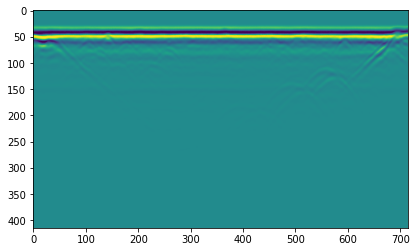

In [6]:
plt.imshow(d)

### Resampling Along Time Axis
Use a discrete Fourier transform, shift, pad, and inverse Fourier transform to resample the input wave form. All input wave forms will be resampled so that they are 120 ns long with a sample rate of 10 samples/ns. Each output wave form will be a vector of 1200 elements.

In [7]:
from real_data_wrangling.reshape import dft_resample, resample_y

In [8]:
output_time_range = 120
sample_rate = 10 # samples per ns

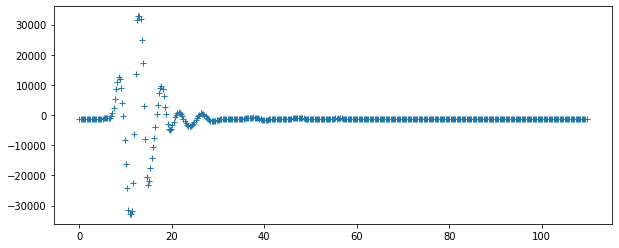

In [9]:
input_time_range = 110
y = d[:, 0]
t = np.arange(0, input_time_range, input_time_range / len(y))

plt.plot(t, y, '+')

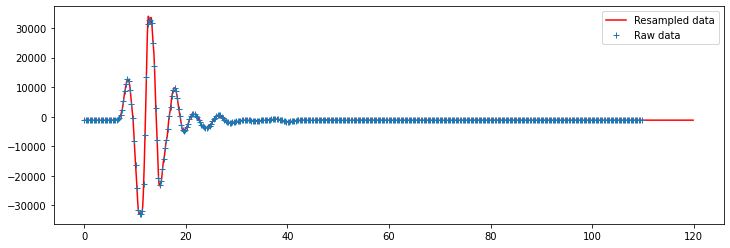

In [10]:
y_resampled = dft_resample(y, input_time_range, sample_rate, output_time_range)
t_resampled = np.arange(0, output_time_range, 1 / sample_rate)

with plt.rc_context({'figure.figsize': [12, 4]}):
    fig, ax = plt.subplots()
    ax.plot(t_resampled, y_resampled, 'r')
    ax.plot(t, y, '+')
    ax.legend(['Resampled data', 'Raw data'])

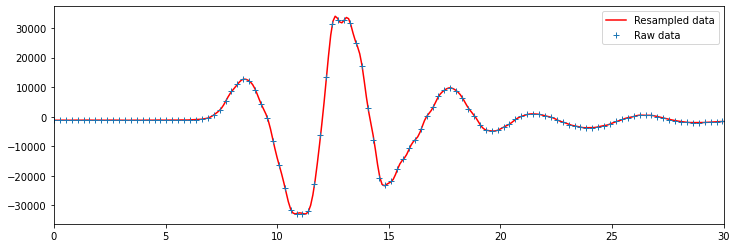

In [11]:
with plt.rc_context({'figure.figsize': [12, 4]}):
    fig, ax = plt.subplots()
    ax.plot(t_resampled, y_resampled, 'r')
    ax.plot(t, y, '+')
    ax.legend(['Resampled data', 'Raw data'])
    ax.set_xlim(0, 30)

Apply resampling method to all a-scans (columns) of the input data.

In [12]:
resampled_scan = resample_y(d, input_time_range, sample_rate, output_time_range)

Comparison of raw and resampled scans.

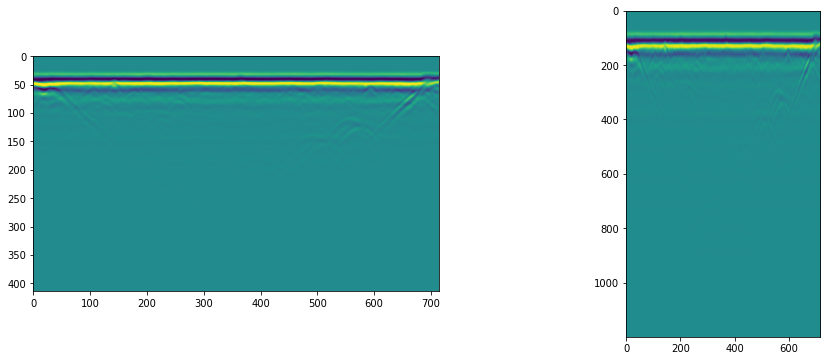

In [13]:
with plt.rc_context({'figure.figsize': [16, 6]}):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(d)
    ax2.imshow(resampled_scan)

## Resampling Along Distance Axis
Since shapes manifest themselves as parabolic curves, use second order polynomial interpolation to upsample the input scans along the x-axis.

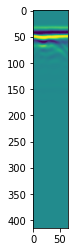

In [14]:
scans_per_m = 33
meters = 2
scans_per_m_output = 50

# Select 2 m worth of scans
s = d[:,0:scans_per_m * meters]
plt.imshow(s)

In [15]:
from real_data_wrangling.reshape import polynomial_resample

In [16]:
x = d[0, 0:scans_per_m * meters]
m = np.linspace(0, meters, scans_per_m * meters)

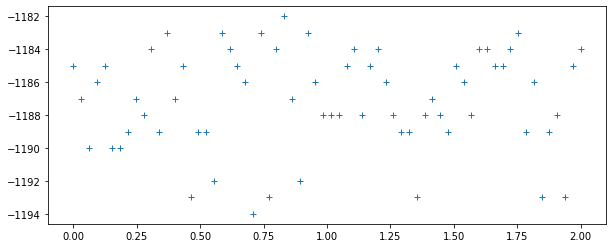

In [17]:
plt.plot(m, x, '+')

In [18]:
x_resampled = polynomial_resample(x, meters, scans_per_m_output * meters)
m_resampled = np.linspace(0, meters, scans_per_m_output * meters)

/Users/jeanruggiero/Projects/masters-thesis/real_data_wrangling/reshape.py:113: RankWarning: Polyfit may be poorly conditioned
  return np.vectorize(lambda d_val: quadratic_interpolate(d, x, d_val))(d_output)


Hypothesis busted? Seems like maybe polynomial resampling won't work here.

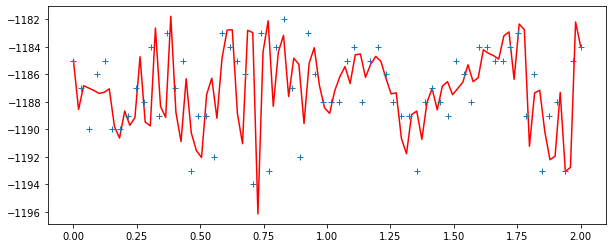

In [19]:
plt.plot(m_resampled, x_resampled, 'r')
plt.plot(m, x, '+')